In [6]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 76 bytes


In [8]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

100% 1.52G/1.52G [01:15<00:00, 21.4MB/s]
100% 1.52G/1.52G [01:15<00:00, 21.6MB/s]


In [9]:
from zipfile import ZipFile
file_name = "/content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [10]:
# Create directories for each class

normal_dir = ['/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal']
stone_dir = ['/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone']
tumor_dir = ['/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor']
cyst_dir = ['/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst']

directory_list = [normal_dir, stone_dir, tumor_dir, cyst_dir]
labels_list = ['Normal', 'Stone', 'Tumor', 'Cyst']

In [11]:
filepaths = []
labels = []

for i, dir_list in enumerate(directory_list):
    for j in dir_list:
        klist = os.listdir(j)
        for k in klist:
            kpath = os.path.join(j,k)

            filepaths.append(kpath)
            labels.append(labels_list[i])

file_series = pd.Series(filepaths, name = 'filepath')
label_series = pd.Series(labels, name = 'labels')
kidney_data = pd.concat([file_series, label_series], axis =1)
kidney_df = pd.DataFrame(kidney_data)
print(kidney_df.head())
print(kidney_df["labels"].value_counts())

                                            filepath  labels
0  /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...  Normal
1  /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...  Normal
2  /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...  Normal
3  /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...  Normal
4  /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...  Normal
labels
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


In [12]:
print("Shape of kidney dataframe is:" , kidney_df.shape)

Shape of kidney dataframe is: (12446, 2)


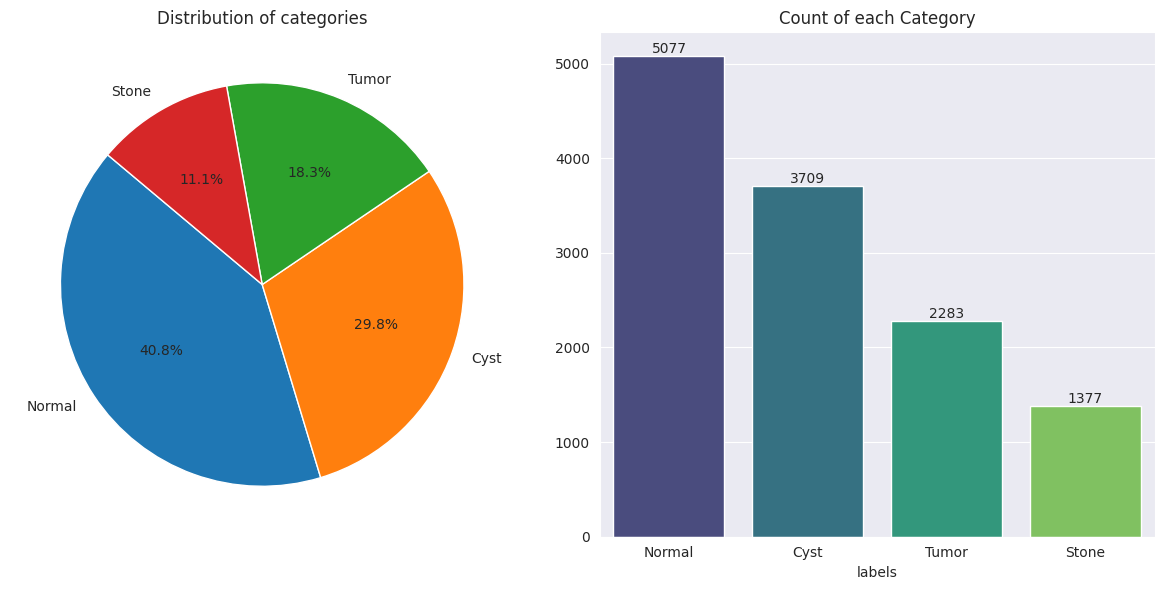

In [13]:
#Count the occurences of each category in the "category" column
#The erro was that I named my label "Label"
count = kidney_df['labels'].value_counts()
#We are separating them into Normal and Pneumonia

#Creating a subplot with two subplots
fig, axs = plt.subplots(1, 2, figsize = (12,6), facecolor = 'white')

#Plot the pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels = count.index, autopct = '%1.1f%%', startangle = 140)
axs[0].set_title('Distribution of categories')

#Plot the bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax = axs[1], palette = 'viridis')
axs[1].set_title('Count of each Category')

# Display numerical values on top of the bars
for i, val in enumerate(count.values):
    axs[1].text(i, val, str(val), ha='center', va='bottom')

#Adjust the Layot
plt.tight_layout()

#Print the plot

plt.show()

In [14]:
train_df, test_images = train_test_split(kidney_df, train_size = 0.7, shuffle = True, random_state = 42)
test_df, valid_df = train_test_split(test_images, train_size = 0.5, shuffle = True, random_state = 42)

print(train_df.shape)
print(test_images.shape)
print(test_df.shape)
print(valid_df.shape)
#Shape = (rows,columns)

(8712, 2)
(3734, 2)
(1867, 2)
(1867, 2)


In [15]:
datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to range [0,1]
    featurewise_center=True,  # normalize pixel values to have mean 0
    featurewise_std_normalization=True,  # normalize pixel values to have std 1
    rotation_range=40,  # randomly rotate images in the range (0-40 degrees)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    zoom_range=0.2,  # randomly zoom into images
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True,  # randomly flip images vertically

)
Datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to range [0,1]
    featurewise_center=True,  # normalize pixel values to have mean 0
    featurewise_std_normalization=True,  # normalize pixel values to have std 1
    rotation_range=0,  # randomly rotate images in the range (0-40 degrees)
    width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    zoom_range=0,  # randomly zoom into images
    horizontal_flip=False,  # randomly flip images horizontally
    vertical_flip=False,  # randomly flip images vertically
)
# Define the DataFrame with file paths and labels
# Modify this according to your actual DataFrame structure

# Define target image size
target_size = (244,244)  # adjust according to your desired image size

# Create a DirectoryIterator
# Assuming you have a directory structure with images, and 'filename' column contains relative paths to these images
# Modify the 'directory' parameter according to your actual directory structure
# 'x_col' parameter specifies the column in the DataFrame containing file paths
# 'y_col' parameter specifies the column in the DataFrame containing labels
# 'class_mode' parameter specifies the type of labels, 'binary' for binary classification, 'categorical' for multi-class classification, etc.
# 'batch_size' parameter specifies the batch size for training
# 'shuffle' parameter specifies whether to shuffle the data
# 'seed' parameter specifies the random seed for shuffling
# 'color_mode' parameter specifies the color mode of the images, 'grayscale' for grayscale, 'rgb' for RGB
# 'target_size' parameter specifies the target image size
# 'validate_filenames' parameter specifies whether to validate image filenames
# 'image_data_generator' parameter specifies the ImageDataGenerator object for preprocessing
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='labels',
    class_mode='categorical',  # adjust according to your classification task
    batch_size=32,
    shuffle=True,
    seed=42,
    color_mode='rgb',
    target_size=target_size,
    validate_filenames=True  # set to True if you want to validate image filenames
)
valid_generator = Datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='labels',
    class_mode='categorical',  # adjust according to your classification task
    batch_size=32,
    shuffle= False,
    color_mode='rgb',
    target_size=target_size,
    validate_filenames=False  # set to True if you want to validate image filenames
)
test_generator = Datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='labels',
    class_mode='categorical',  # adjust according to your classification task
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    target_size=target_size,
    validate_filenames=False  # set to True if you want to validate image filenames
)

Found 8712 validated image filenames belonging to 4 classes.
Found 1867 non-validated image filenames belonging to 4 classes.
Found 1867 non-validated image filenames belonging to 4 classes.


In [16]:
for image_batch, labels_batch in train_generator:
    print ("Shape of X train: ", image_batch.shape)
    print ("Shape of Y train: ", image_batch.shape)
    break
for image_batch, labels_batch in valid_generator:
    print ("Shape of X validation: ", image_batch.shape)
    print ("Shape of Y validation: ", image_batch.shape)
    break
for image_batch, labels_batch in test_generator:
    print ("Shape of X test: ", image_batch.shape)
    print ("Shape of Y test: ", image_batch.shape)
    break

Shape of X train:  (32, 244, 244, 3)
Shape of Y train:  (32, 244, 244, 3)
Shape of X validation:  (32, 244, 244, 3)
Shape of Y validation:  (32, 244, 244, 3)
Shape of X test:  (32, 244, 244, 3)
Shape of Y test:  (32, 244, 244, 3)


In [17]:
import os

# Path to the directory containing the kidney dataset
data_dir = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Check if the directory exists
if os.path.exists(data_dir):
    # List all directories in the dataset directory
    subfolders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

    # Print the list of subfolders (classes)
    print("Subfolders (classes) in the directory:")
    for cls in subfolders:
        print(cls)
else:
    print("Directory not found:", data_dir)


Subfolders (classes) in the directory:
Tumor
Cyst
Stone
Normal


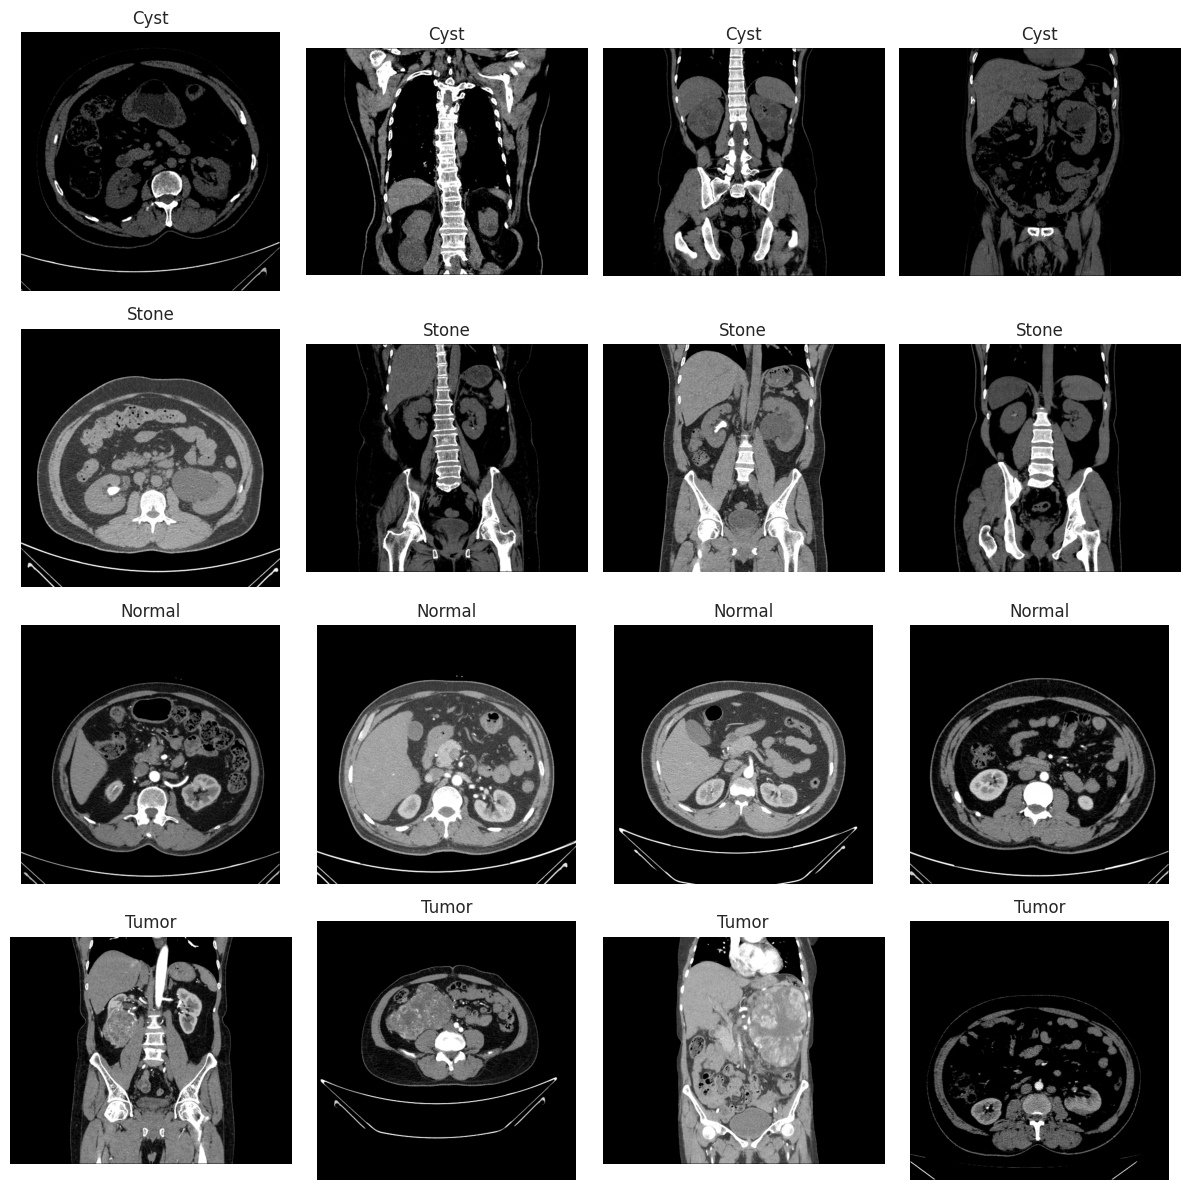

In [18]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# Path to the directory containing the kidney dataset
data_dir = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# List of subfolders (classes) in the dataset
classes = ['Cyst', 'Stone', 'Normal', 'Tumor']

# Number of sample images to display from each class
num_samples = 4

# Plot sample images from each class
plt.figure(figsize=(12, 12))

# Loop through each class
for i, cls in enumerate(classes, 1):
    # Path to the class directory
    cls_dir = os.path.join(data_dir, cls)
    # List of image files in the class directory
    img_files = os.listdir(cls_dir)
    # Randomly select sample images
    sample_files = random.sample(img_files, num_samples)

    # Plot sample images
    for j, img_file in enumerate(sample_files, 1):
        img_path = os.path.join(cls_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format for plotting
        plt.subplot(len(classes), num_samples, (i-1)*num_samples + j)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
classes=list(train_generator.class_indices.keys())
print ("The training classes are:", classes)
classes=list(valid_generator.class_indices.keys())
print ("The validation classes are:",classes)
classes=list(test_generator.class_indices.keys())
print ("The testing classes are:",classes)

The training classes are: ['Cyst', 'Normal', 'Stone', 'Tumor']
The validation classes are: ['Cyst', 'Normal', 'Stone', 'Tumor']
The testing classes are: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [20]:
#Google Net (Inception v1)
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# Evaluate the model
def model_evaluation(model, test_generator):
    train_score = model.evaluate(train_generator, verbose= 1)
    valid_score = model.evaluate(valid_generator, verbose= 1)
    test_score = model.evaluate(test_generator, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

def plot_confusion_matrix(model, test_generator):
    # Get Predictions
    preds = model.predict(test_generator)
    y_pred = np.argmax(preds, axis=1)

    g_dict = test_generator.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_generator.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, AveragePooling2D, Dropout, Flatten, Dense
from keras.models import Model

def inception_module(x, filters):
    # 1x1 convolution
    conv_1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)

    # 3x3 convolution
    conv_3x3 = Conv2D(filters=filters[1], kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)

    # 5x5 convolution
    conv_5x5 = Conv2D(filters=filters[2], kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')(x)

    # Max pooling
    max_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    # Concatenate the outputs
    return concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool], axis=-1)

# Input layer
input_layer = Input(shape=(224, 224, 3))

# Stem
stem = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
stem = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(stem)
stem = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(stem)
stem = Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(stem)
stem = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(stem)

# Inception modules
inception1 = inception_module(stem, filters=[64, 96, 128])
inception2 = inception_module(inception1, filters=[128, 128, 192])

# Global average pooling
avg_pool = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(inception2)

# Flatten
flatten = Flatten()(avg_pool)

# Dense layers
dense1 = Dense(units=1024, activation='relu')(flatten)
dropout1 = Dropout(0.4)(dense1)
dense2 = Dense(units=4, activation='softmax')(dropout1)

# Create the model
googlenet = Model(inputs=input_layer, outputs=dense2)

# Compile the model
googlenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
googlenet.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 112, 112, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)           0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 56, 56, 64)           4160      ['max_pooling2d_4[0][0]'

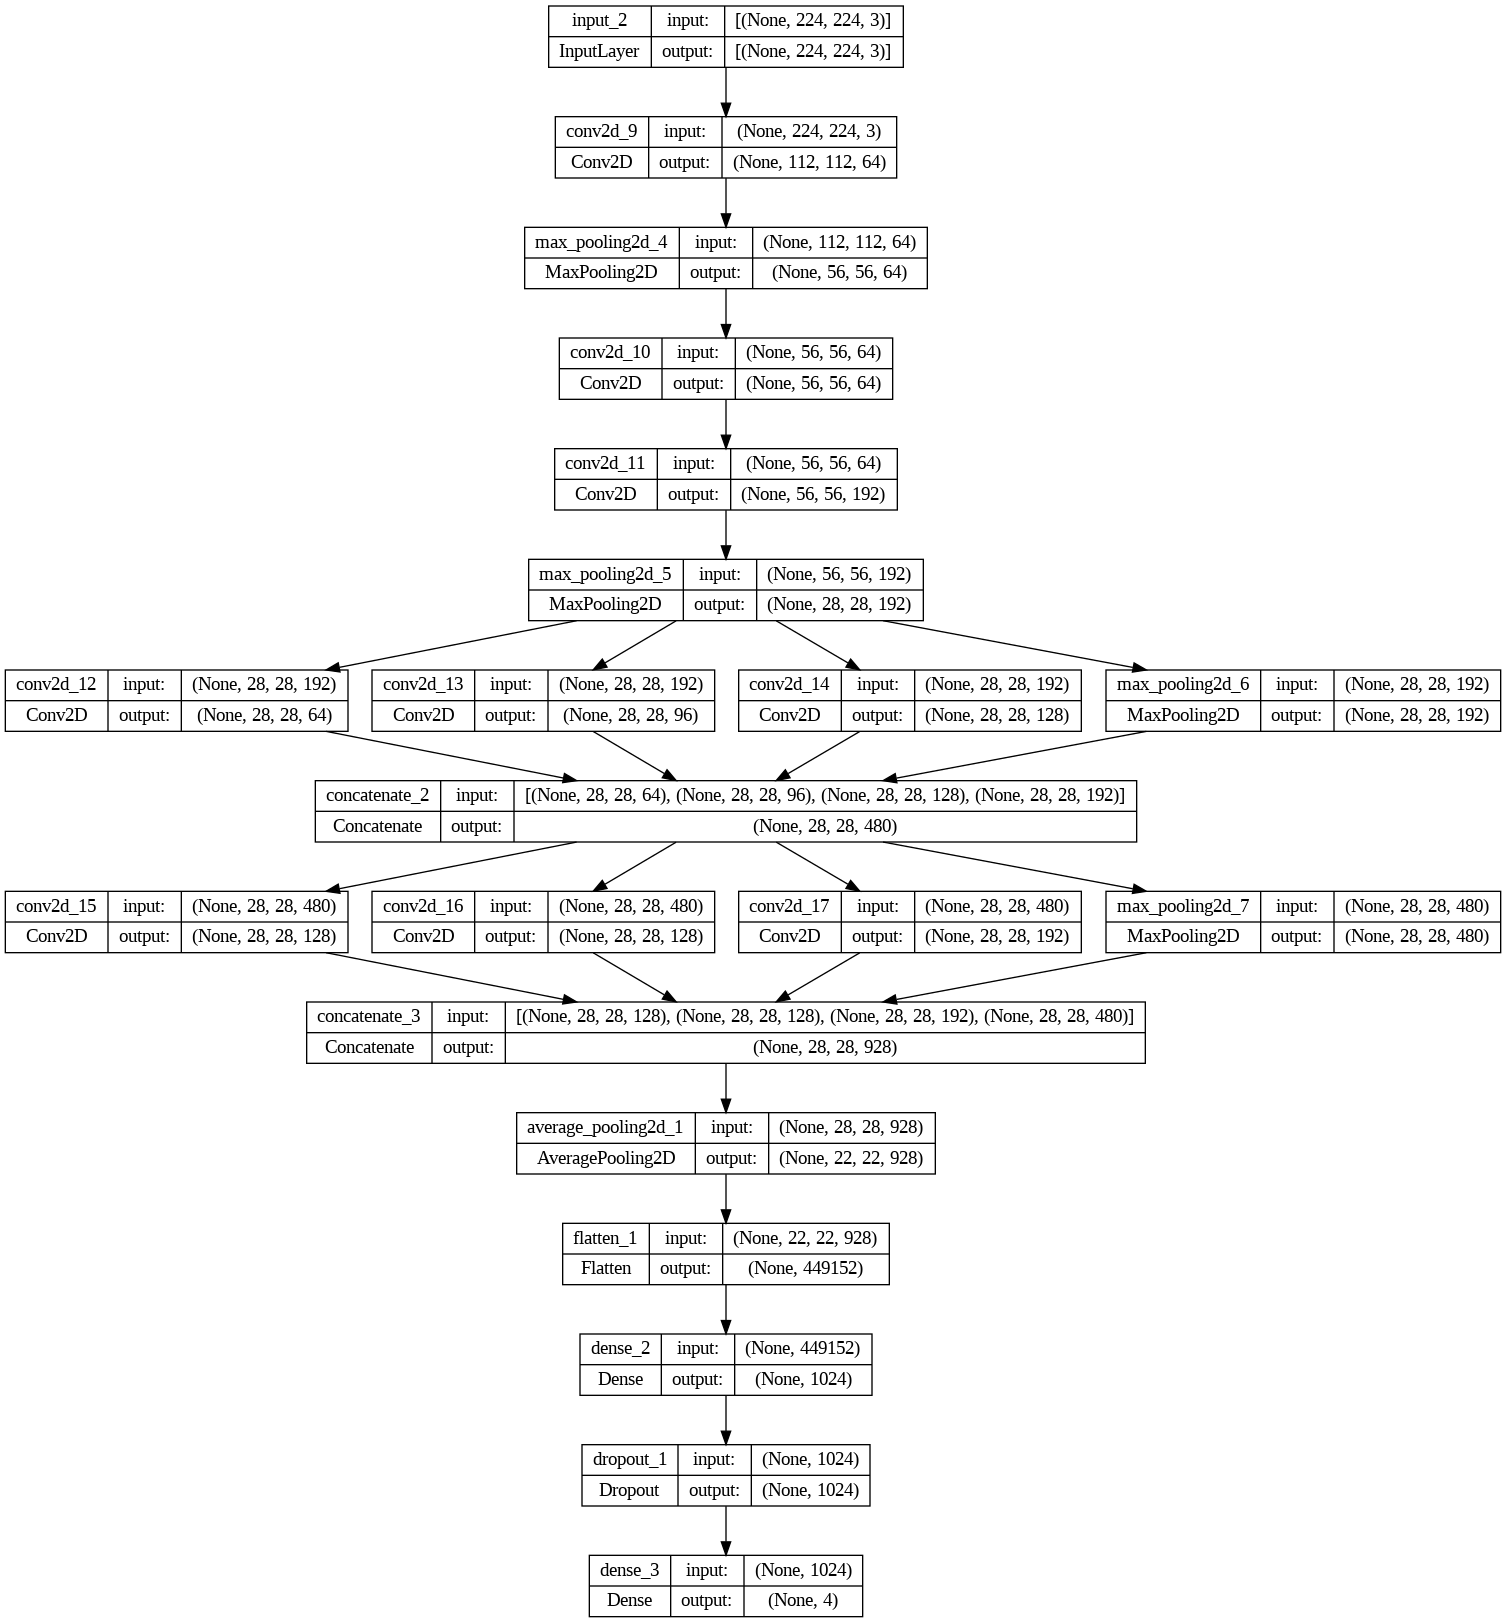

In [ ]:
from keras.utils import plot_model

# Assuming you have already defined the 'googlenet' model
plot_model(googlenet, to_file='googlenet_plot.png', show_shapes=True, show_layer_names=True)


In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

# Define the GoogleNet model
model = Sequential([
    Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.01),
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define number of epochs
epochs = 100

# Train the model with early stopping
history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=[early_stopping], verbose=1)


Epoch 1/100
273/273 [==============================] - 179s 590ms/step - loss: 1.1246 - accuracy: 0.6061 - val_loss: 1.7812 - val_accuracy: 0.4365
Epoch 2/100
273/273 [==============================] - 158s 577ms/step - loss: 0.7404 - accuracy: 0.7041 - val_loss: 1.2525 - val_accuracy: 0.4987
Epoch 3/100
273/273 [==============================] - 157s 576ms/step - loss: 0.6416 - accuracy: 0.7429 - val_loss: 0.4936 - val_accuracy: 0.8243
Epoch 4/100
273/273 [==============================] - 157s 574ms/step - loss: 0.5537 - accuracy: 0.7817 - val_loss: 0.4802 - val_accuracy: 0.8093
Epoch 5/100
273/273 [==============================] - 157s 577ms/step - loss: 0.4815 - accuracy: 0.8108 - val_loss: 0.4922 - val_accuracy: 0.8254
Epoch 6/100
273/273 [==============================] - 158s 578ms/step - loss: 0.4376 - accuracy: 0.8275 - val_loss: 0.3547 - val_accuracy: 0.8677
Epoch 7/100
273/273 [==============================] - 157s 575ms/step - loss: 0.3848 - accuracy: 0.8519 - val_loss: 0

59/59 [==============================] - 8s 138ms/step


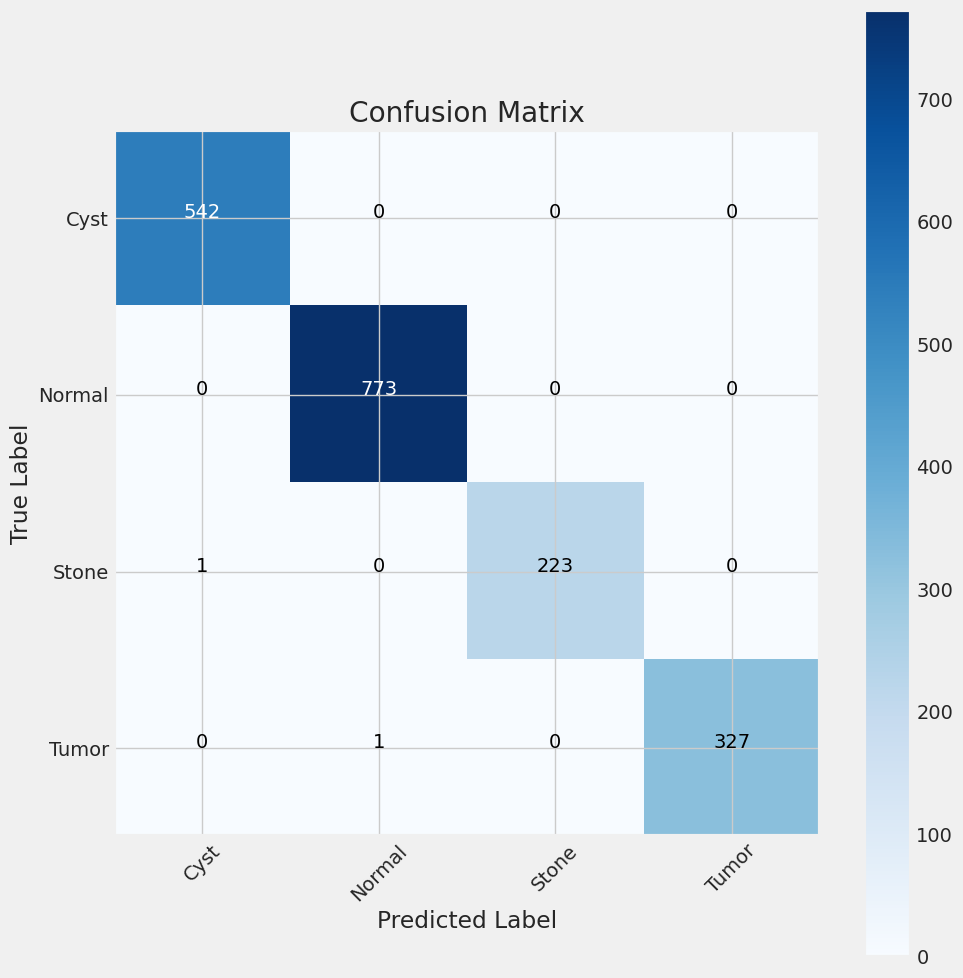

59/59 [==============================] - 8s 138ms/step - loss: 0.0062 - accuracy: 0.9989
Train Loss:  0.05863329768180847
Train Accuracy:  0.9784205555915833
--------------------
Validation Loss:  0.009822288528084755
Validation Accuracy:  0.9983931183815002
--------------------
Test Loss:  0.006242585834115744
Test Accuracy:  0.9989287853240967


In [23]:
plot_confusion_matrix(model, test_generator)
model_evaluation(model, test_generator)


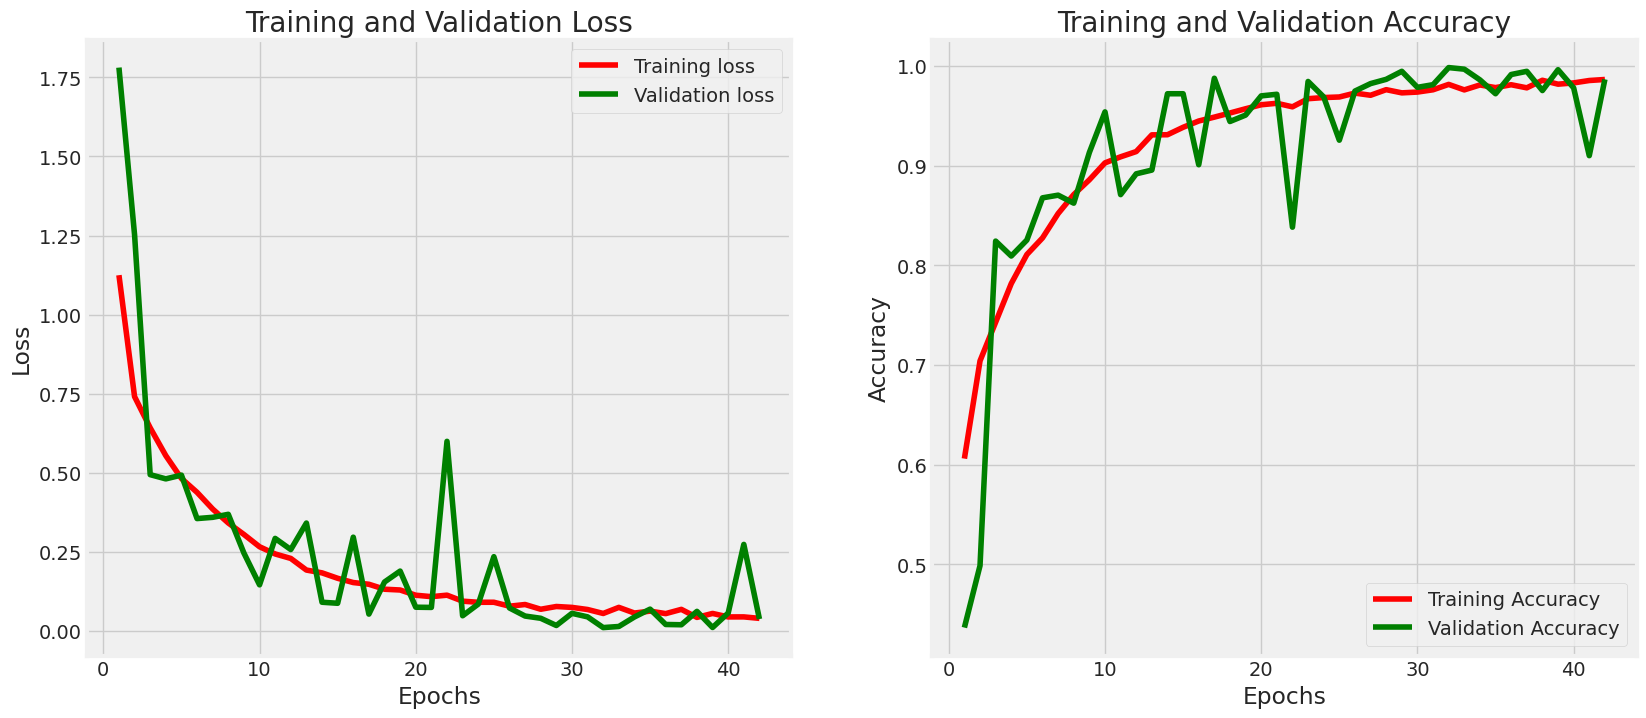

In [22]:
model_performance(history, epochs)

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming model is your trained model and test_generator is your test data generator

# Generate predictions for the test dataset
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Get the predicted labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred_labels, average='weighted')  # Use 'micro', 'macro', or 'weighted' average depending on your preference
recall = recall_score(y_true, y_pred_labels, average='weighted')  # Use 'micro', 'macro', or 'weighted' average depending on your preference
f1 = f1_score(y_true, y_pred_labels, average='weighted')  # Use 'micro', 'macro', or 'weighted' average depending on your preference

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


59/59 [==============================] - 9s 147ms/step
Precision: 0.9989304411410231
Recall: 0.9989287627209427
F1 Score: 0.9989281746698915


In [62]:
#CNN
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tracc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_generator, verbose= 1)
    valid_score = model.evaluate(valid_generator, verbose= 1)
    test_score = model.evaluate(test_generator, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

    # Confusion Matrix
def plot_confusion_matrix(model, test_generator):
    # Get Predictions
    preds = model.predict(test_generator)
    y_pred = np.argmax(preds, axis=1)

    g_dict = test_generator.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_generator.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

In [63]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
     keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization_18 (Ba  (None, 73, 73, 128)       512       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_19 (Ba  (None, 73, 73, 256)       1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 256)       0         
 g2D)                                                            
                                                      

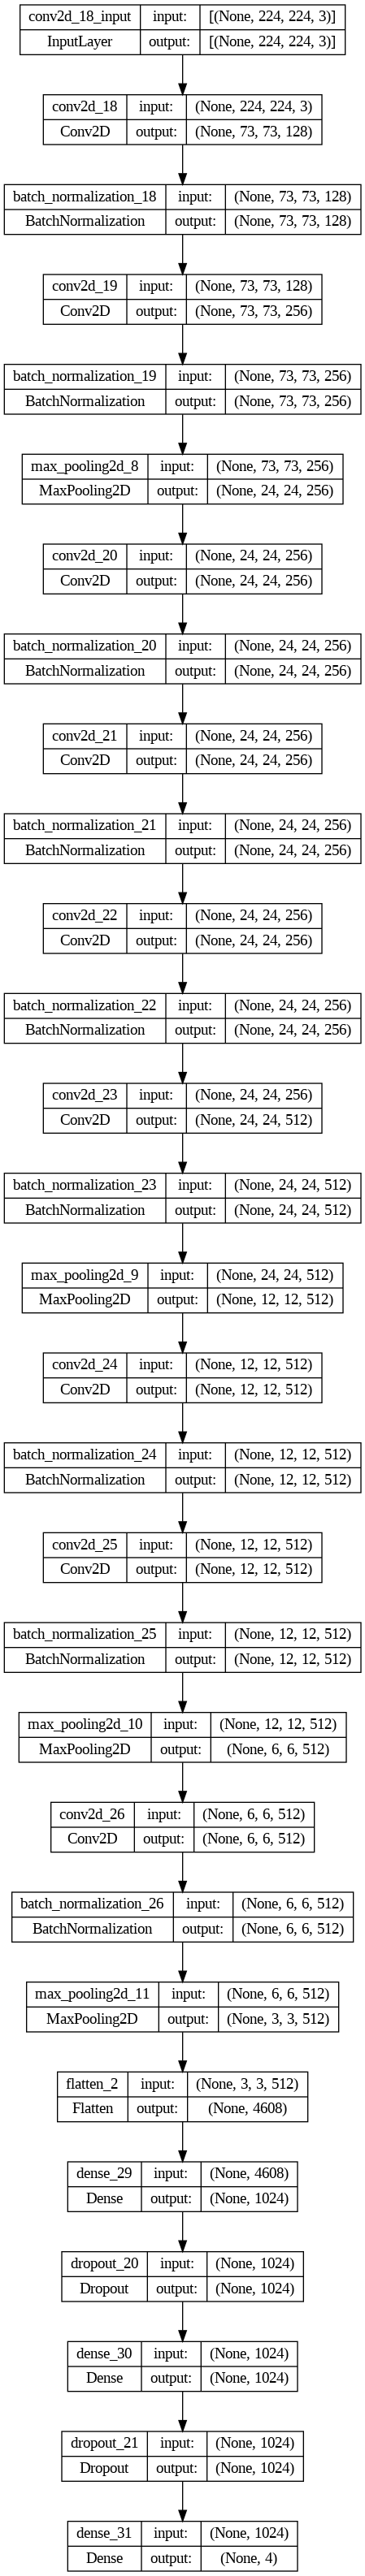

In [64]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/30
273/273 [==============================] - 172s 626ms/step - loss: 0.8741 - accuracy: 0.6556 - val_loss: 1.7014 - val_accuracy: 0.4274
Epoch 2/30
273/273 [==============================] - 172s 630ms/step - loss: 0.7099 - accuracy: 0.7165 - val_loss: 0.7052 - val_accuracy: 0.7606
Epoch 3/30
273/273 [==============================] - 167s 612ms/step - loss: 0.6032 - accuracy: 0.7648 - val_loss: 0.6677 - val_accuracy: 0.7574
Epoch 4/30
273/273 [==============================] - 171s 625ms/step - loss: 0.5336 - accuracy: 0.7918 - val_loss: 0.7559 - val_accuracy: 0.7622
Epoch 5/30
273/273 [==============================] - 169s 618ms/step - loss: 0.4668 - accuracy: 0.8180 - val_loss: 0.4321 - val_accuracy: 0.8190
Epoch 6/30
273/273 [==============================] - 170s 624ms/step - loss: 0.4175 - accuracy: 0.8422 - val_loss: 0.2977 - val_accuracy: 0.8763
Epoch 7/30
273/273 [==============================] - 169s 617ms/step - loss: 0.3778 - accuracy: 0.8553 - val_loss: 0.9061 -

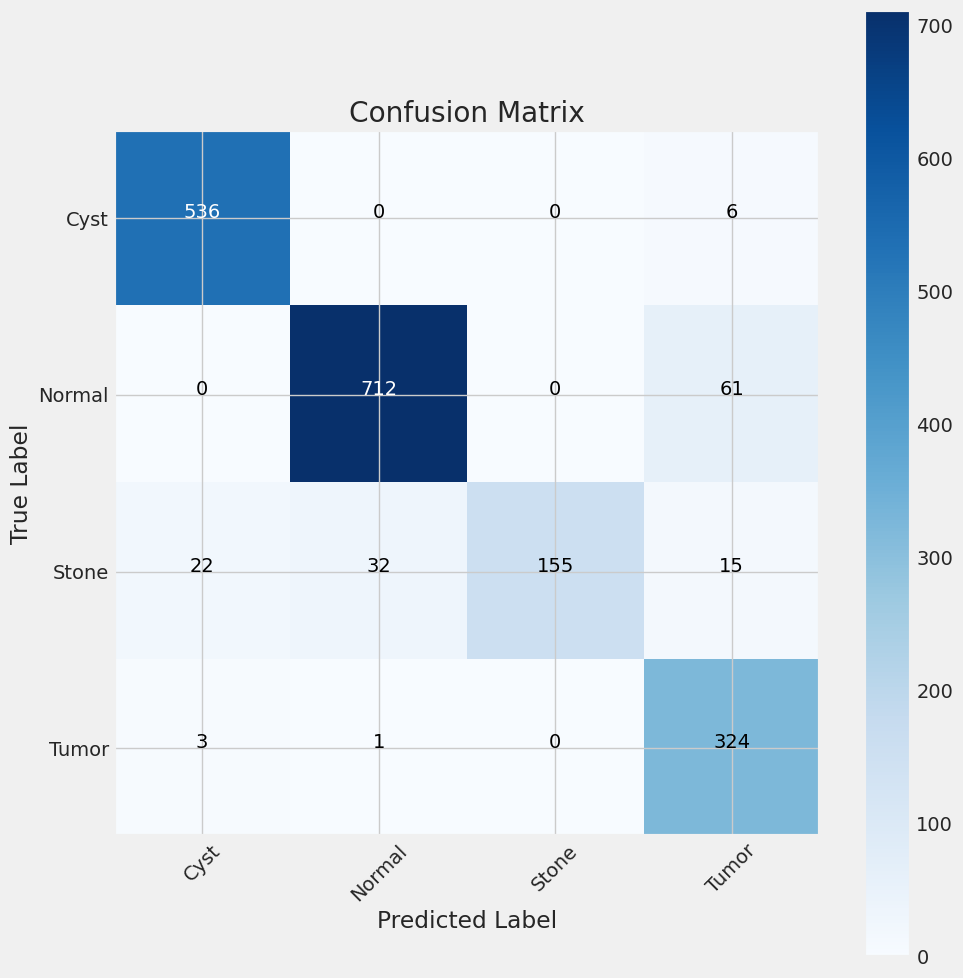

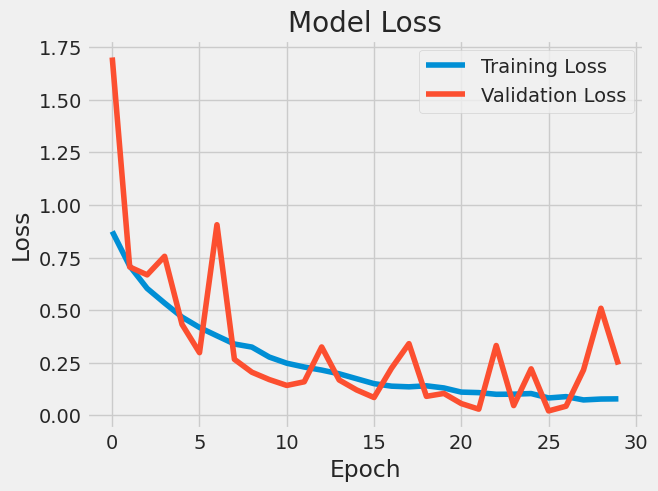

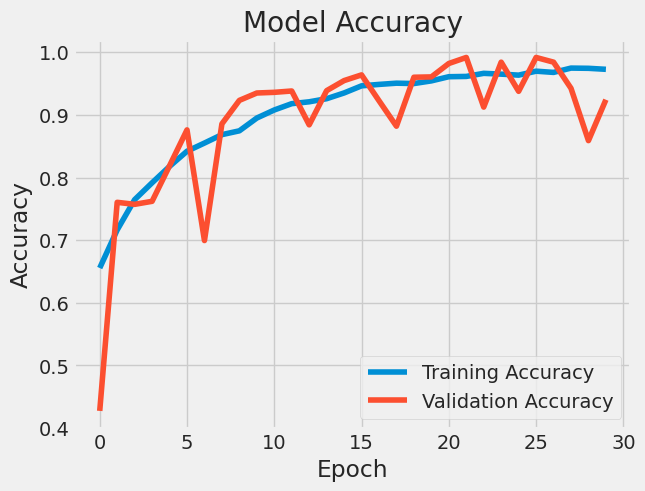

In [66]:
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Set number of epochs
epochs = 30

# Train the model
history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=[early_stopping], verbose=1)

# Evaluate the model
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
valid_loss, valid_accuracy = model.evaluate(valid_generator, verbose=1)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("Train Loss: ", train_loss)
print("Train Accuracy: ", train_accuracy)
print('-' * 20)
print("Validation Loss: ", valid_loss)
print("Validation Accuracy: ", valid_accuracy)
print('-' * 20)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

# Prediction
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

# Precision, Recall, F1-Score
precision = precision_score(test_true_labels, test_pred_labels, average='weighted')
recall = recall_score(test_true_labels, test_pred_labels, average='weighted')
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [70]:
#Resnet50
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Function to plot training history
def model_performance(history, epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to evaluate the model
def model_evaluation(model, train_generator, valid_generator, test_generator):
    train_score = model.evaluate(train_generator, verbose=1)
    valid_score = model.evaluate(valid_generator, verbose=1)
    test_score = model.evaluate(test_generator, verbose=1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

# Function to plot confusion matrix
def plot_confusion_matrix(model, test_generator):
    preds = model.predict(test_generator)
    y_pred = np.argmax(preds, axis=1)

    g_dict = test_generator.class_indices
    classes = list(g_dict.keys())

    cm = confusion_matrix(test_generator.classes, y_pred)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()


In [36]:
import tensorflow as tf
from tensorflow import keras

# Define the ResNet50 base model
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
model = keras.models.Sequential()

# Add the ResNet50 base model to the Sequential model
model.add(base_model)

# Add global average pooling layer
model.add(keras.layers.GlobalAveragePooling2D())

# Add dense layers with dropout
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))

# Add output layer
model.add(keras.layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

# Print model summary
model.summary()


94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              

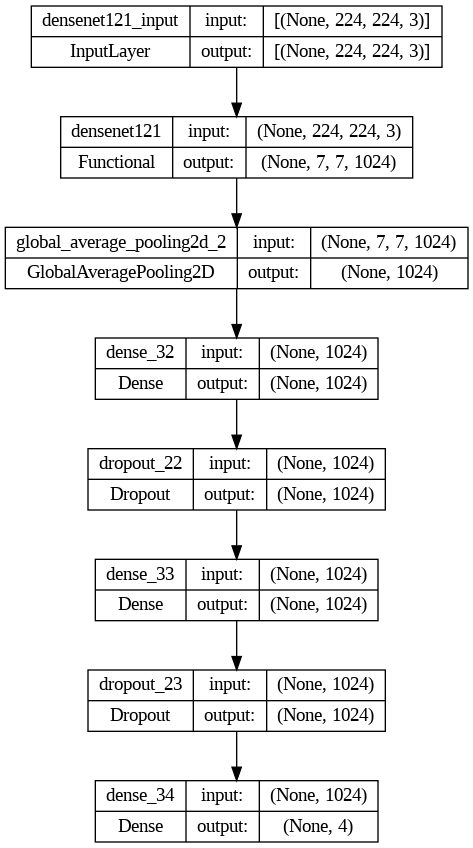

In [71]:
from keras.utils import plot_model

# Assuming you have already defined your ResNet model and named it 'model'
plot_model(model, to_file='resnet_model_plot.png', show_shapes=True, show_layer_names=True)


Epoch 1/30
273/273 [==============================] - 196s 717ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.0052 - val_accuracy: 0.9984
Epoch 2/30
273/273 [==============================] - 197s 720ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.0033 - val_accuracy: 0.9995
Epoch 3/30
273/273 [==============================] - 195s 713ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 4.0267e-04 - val_accuracy: 1.0000
Epoch 4/30
273/273 [==============================] - 196s 716ms/step - loss: 0.0039 - accuracy: 0.9984 - val_loss: 0.0018 - val_accuracy: 0.9995
Epoch 5/30
273/273 [==============================] - 197s 723ms/step - loss: 0.0043 - accuracy: 0.9984 - val_loss: 0.0011 - val_accuracy: 0.9995
Epoch 6/30
273/273 [==============================] - 200s 731ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0151 - val_accuracy: 0.9941
Epoch 7/30
273/273 [==============================] - 198s 726ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 1.16

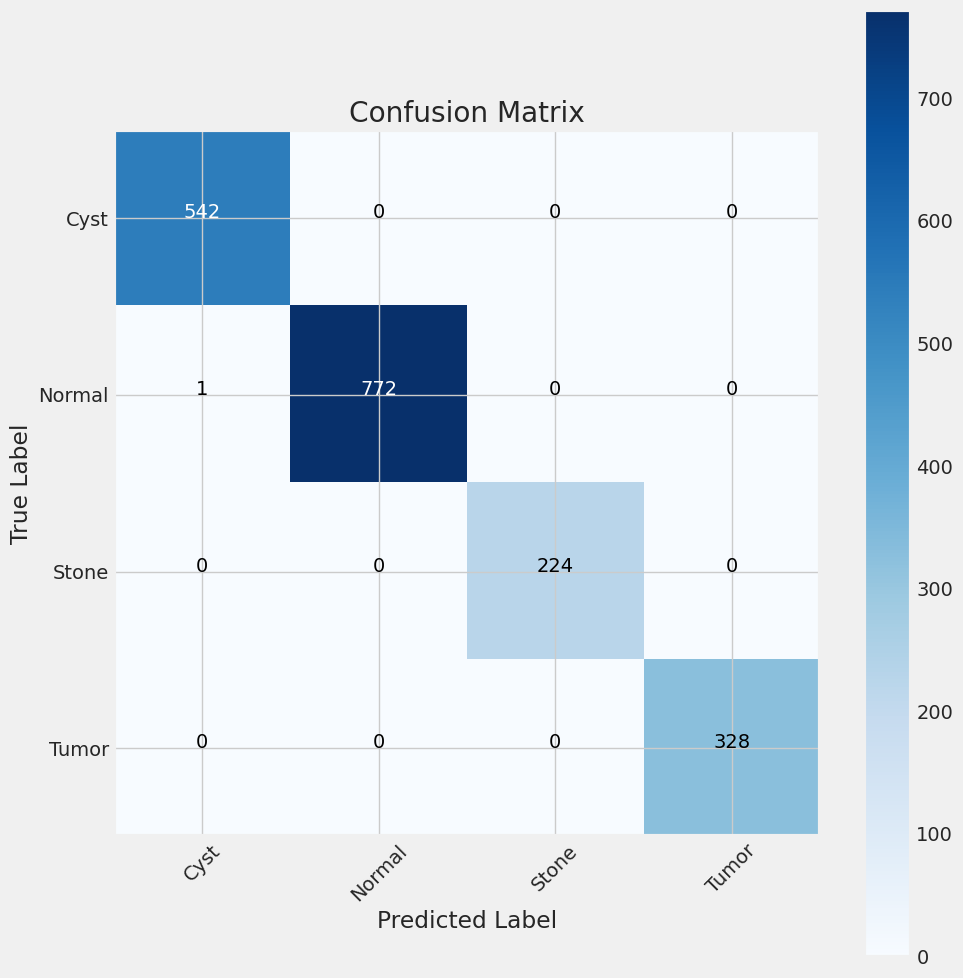

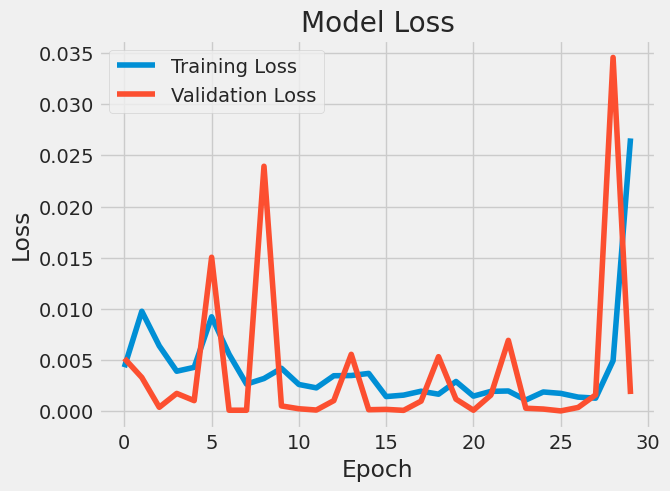

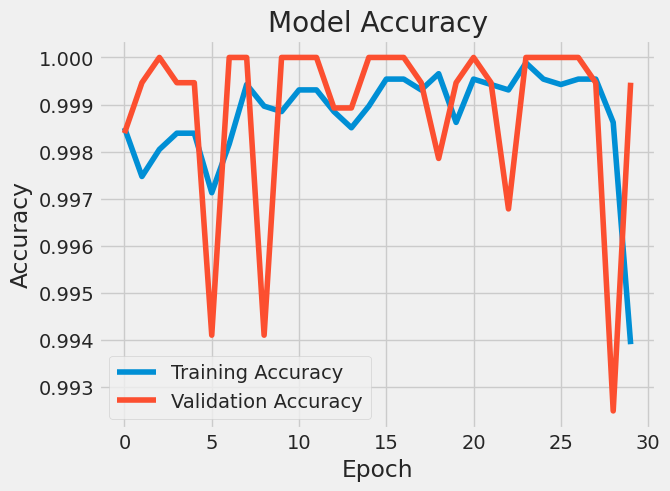

In [74]:
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Set number of epochs
epochs =20

# Train the model
history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=[early_stopping], verbose=1)

# Evaluate the model
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
valid_loss, valid_accuracy = model.evaluate(valid_generator, verbose=1)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("Train Loss: ", train_loss)
print("Train Accuracy: ", train_accuracy)
print('-' * 20)
print("Validation Loss: ", valid_loss)
print("Validation Accuracy: ", valid_accuracy)
print('-' * 20)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

# Prediction
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

# Precision, Recall, F1-Score
precision = precision_score(test_true_labels, test_pred_labels, average='weighted')
recall = recall_score(test_true_labels, test_pred_labels, average='weighted')
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [67]:
#dense net
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Function to plot training history
def model_performance(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(tr_acc) + 1)

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to evaluate the model
def model_evaluation(model, train_generator, valid_generator, test_generator):
    train_score = model.evaluate(train_generator, verbose=1)
    valid_score = model.evaluate(valid_generator, verbose=1)
    test_score = model.evaluate(test_generator, verbose=1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

# Function to plot confusion matrix
def plot_confusion_matrix(model, test_generator):
    preds = model.predict(test_generator)
    y_pred = np.argmax(preds, axis=1)

    g_dict = test_generator.class_indices
    classes = list(g_dict.keys())

    cm = confusion_matrix(test_generator.classes, y_pred)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()


In [68]:
import tensorflow as tf
from tensorflow import keras

# Define the DenseNet base model
base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
model = keras.models.Sequential()

# Add the DenseNet base model to the Sequential model
model.add(base_model)

# Add global average pooling layer
model.add(keras.layers.GlobalAveragePooling2D())

# Add dense layers with dropout
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))

# Add output layer
model.add(keras.layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_32 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_22 (Dropout)        (None, 1024)              0         
                                                                 
 dense_33 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_23 (Dropout)        (None, 1024)              0         
                                                      

Epoch 1/20
273/273 [==============================] - 275s 725ms/step - loss: 0.5976 - accuracy: 0.7738 - val_loss: 0.8569 - val_accuracy: 0.6610
Epoch 2/20
273/273 [==============================] - 197s 721ms/step - loss: 0.1401 - accuracy: 0.9521 - val_loss: 0.0293 - val_accuracy: 0.9909
Epoch 3/20
273/273 [==============================] - 200s 733ms/step - loss: 0.0703 - accuracy: 0.9769 - val_loss: 0.0266 - val_accuracy: 0.9914
Epoch 4/20
273/273 [==============================] - 204s 747ms/step - loss: 0.0500 - accuracy: 0.9840 - val_loss: 0.0394 - val_accuracy: 0.9871
Epoch 5/20
273/273 [==============================] - 199s 728ms/step - loss: 0.0318 - accuracy: 0.9909 - val_loss: 0.0563 - val_accuracy: 0.9829
Epoch 6/20
273/273 [==============================] - 200s 731ms/step - loss: 0.0347 - accuracy: 0.9889 - val_loss: 0.0068 - val_accuracy: 0.9973
Epoch 7/20
273/273 [==============================] - 198s 724ms/step - loss: 0.0285 - accuracy: 0.9908 - val_loss: 0.0077 -

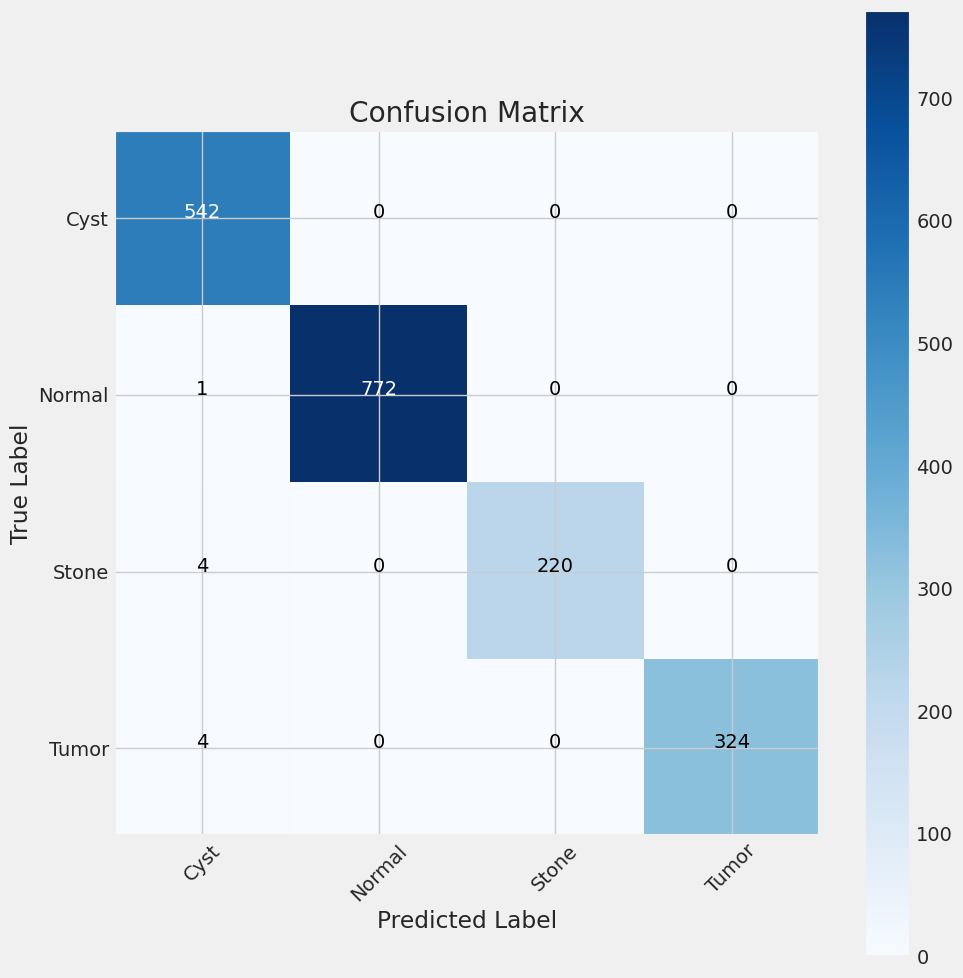

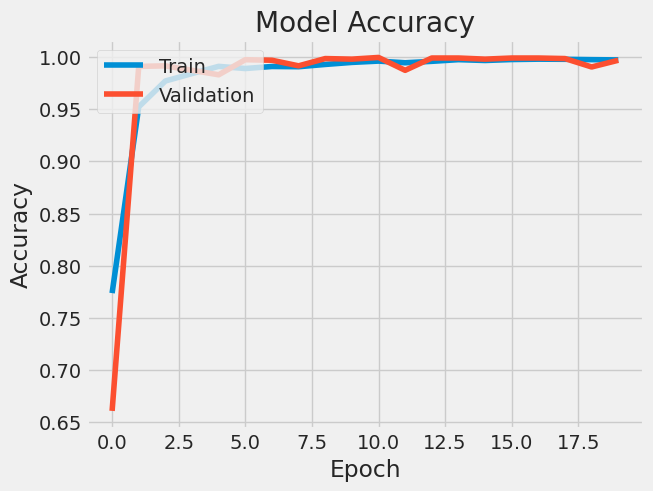

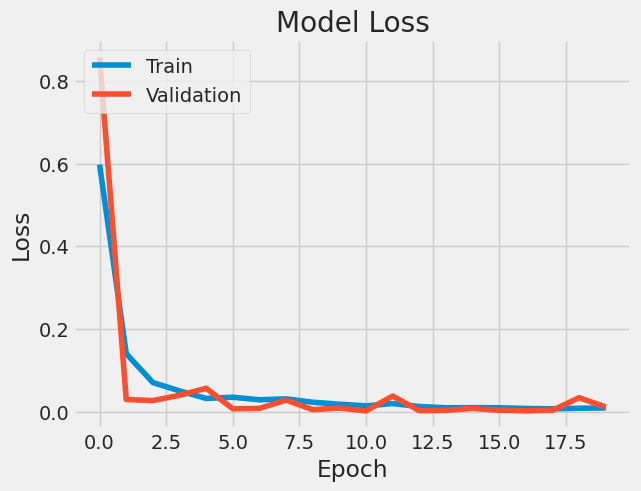

59/59 [==============================] - 9s 160ms/step
Classification Report:
              precision    recall  f1-score   support

        Cyst       0.98      1.00      0.99       542
      Normal       1.00      1.00      1.00       773
       Stone       1.00      0.98      0.99       224
       Tumor       1.00      0.99      0.99       328

    accuracy                           1.00      1867
   macro avg       1.00      0.99      0.99      1867
weighted avg       1.00      1.00      1.00      1867



In [69]:
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Set number of epochs
epochs = 20

# Train the model
history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=[early_stopping], verbose=1)

# Evaluate the model
train_score = model.evaluate(train_generator, verbose=1)
valid_score = model.evaluate(valid_generator, verbose=1)
test_score = model.evaluate(test_generator, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Confusion Matrix
def plot_confusion_matrix(model, test_generator):
    preds = model.predict(test_generator)
    y_pred = np.argmax(preds, axis=1)

    g_dict = test_generator.class_indices
    classes = list(g_dict.keys())

    cm = confusion_matrix(test_generator.classes, y_pred)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

# Plot training history
def plot_training_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(model, test_generator)

# Plot training history
plot_training_history(history)

# Get predictions
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

# Compute and print precision, recall, and F1-score
report = classification_report(test_true_labels, test_pred_labels, target_names=classes)
print("Classification Report:")
print(report)
